-----
# ANALYSE DE DONNEES - 7 ANALYSES

-----
## 1. Chargement et Préparation
On charge les bibliothèques et les fichiers nécessaires.

In [7]:
import pandas as pd
import numpy as np
import re
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Configuration graphique
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Chargement des données...")
# On charge les fichiers localement depuis mon ordinateur
df_business = pd.read_json('data/yelp_academic_dataset_business.json', lines=True)
df_review = pd.read_json('data/yelp_academic_reviews4students.jsonl', lines=True)
df_user = pd.read_json('data/yelp_academic_dataset_user4students.jsonl', lines=True)

print("Données prêtes.")

Chargement des données...
Données prêtes.


-----
## 2. Répartition des avis par catégorie
Question : Quelles sont les catégories les plus présentes ?

- Répartition des avis par catégorie (Restaurants, Bars, Hotels, etc.)

Ici, une entreprise peut avoir plusieurs catégories ("Mexican, Restaurants, Tacos"). On doit séparer tout ça pour compter correctement.

C:\Users\lucie\AppData\Local\Temp\ipykernel_396\3236929040.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette="viridis")


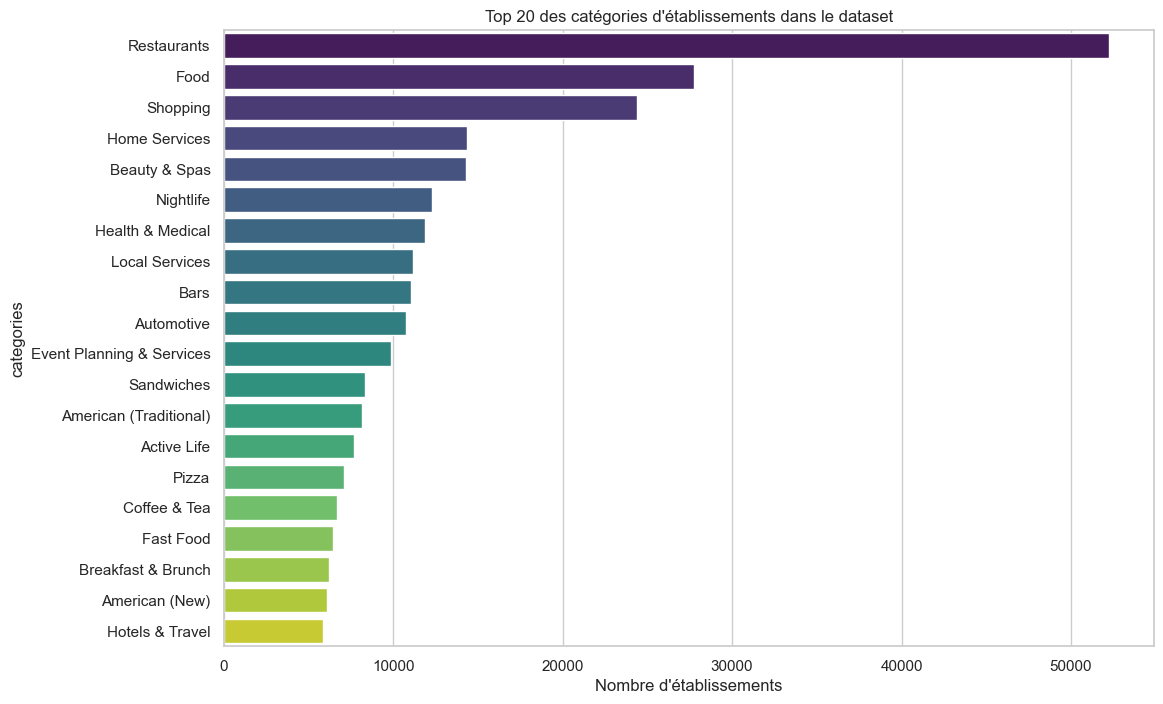

In [2]:
# On sépare la colonne 'categories' (qui est une liste de mots séparés par des virgules)
# explode() permet de créer une ligne par catégorie
cats = df_business['categories'].dropna().str.split(', ').explode()

# On compte le top 20
top_cats = cats.value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_cats.values, y=top_cats.index, palette="viridis")
plt.title("Top 20 des catégories d'établissements dans le dataset")
plt.xlabel("Nombre d'établissements")
plt.show()

-----
## 3. Popularité vs Note & Sévérité des "Gros Reviewers"
Question : Les lieux populaires sont-ils mieux notés ? Les experts sont-ils plus méchants ?
- Lien entre le nombre total d’avis d’un business et la note moyenne du business Les business très populaires sont-ils plus sévèrement jugés ?

On va créer des groupes (peu connu, connu, très connu, star) pour simplifier la lecture en fonction de leur nombre totale d'avis
et pour l'autre graphique on va créer des groupes (de novice, habituer, expert) en fonction du fichier user

C:\Users\lucie\AppData\Local\Temp\ipykernel_396\1162699059.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_business, x='pop_category', y='stars', palette="magma")


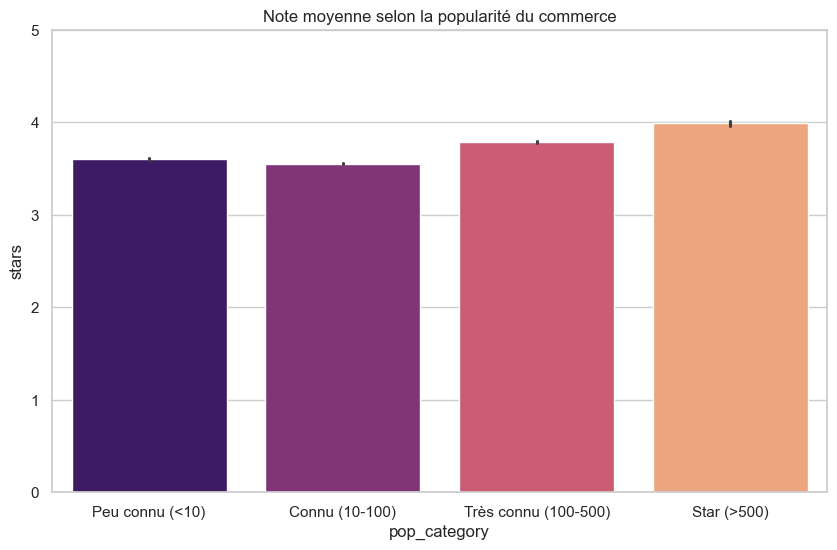

C:\Users\lucie\AppData\Local\Temp\ipykernel_396\1162699059.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_merged, x='user_exp', y='stars', palette="coolwarm")


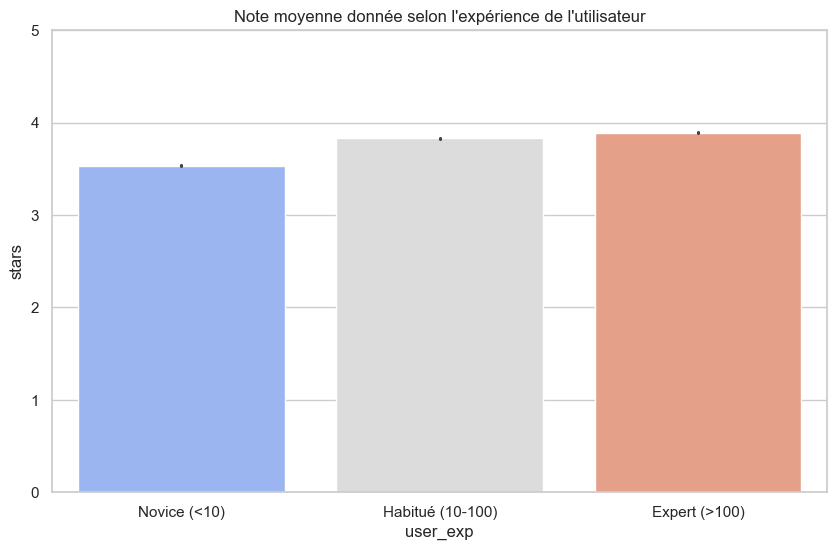

In [3]:
# ANALYSE BUSINESS : Popularité vs Note
# On classe les business par popularité
df_business['pop_category'] = pd.cut(
    df_business['review_count'], 
    bins=[0, 10, 100, 500, 100000], 
    labels=['Peu connu (<10)', 'Connu (10-100)', 'Très connu (100-500)', 'Star (>500)']
)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_business, x='pop_category', y='stars', palette="magma")
plt.title("Note moyenne selon la popularité du commerce")
plt.ylim(0, 5)
plt.show()

# ANALYSE USER : Expérience vs Sévérité
# On fusionne Review et User pour savoir qui a écrit quoi
df_merged = df_review[['user_id', 'stars', 'text']].merge(
    df_user[['user_id', 'review_count']], 
    on='user_id', 
    how='inner'
)

# On classe les utilisateurs par expérience
df_merged['user_exp'] = pd.cut(
    df_merged['review_count'], 
    bins=[0, 10, 100, 100000], 
    labels=['Novice (<10)', 'Habitué (10-100)', 'Expert (>100)']
)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_merged, x='user_exp', y='stars', palette="coolwarm")
plt.title("Note moyenne donnée selon l'expérience de l'utilisateur")
plt.ylim(0, 5)
plt.show()

-----
## 4. Longueur des avis (Détails & Polarité)
Question : Les experts écrivent-ils plus ? Les avis négatifs sont-ils plus longs ?

- Les “gros reviewers” sont-ils plus sévères que les autres ?

C:\Users\lucie\AppData\Local\Temp\ipykernel_396\4028037470.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_merged, x='user_exp', y='text_len', palette="Blues")


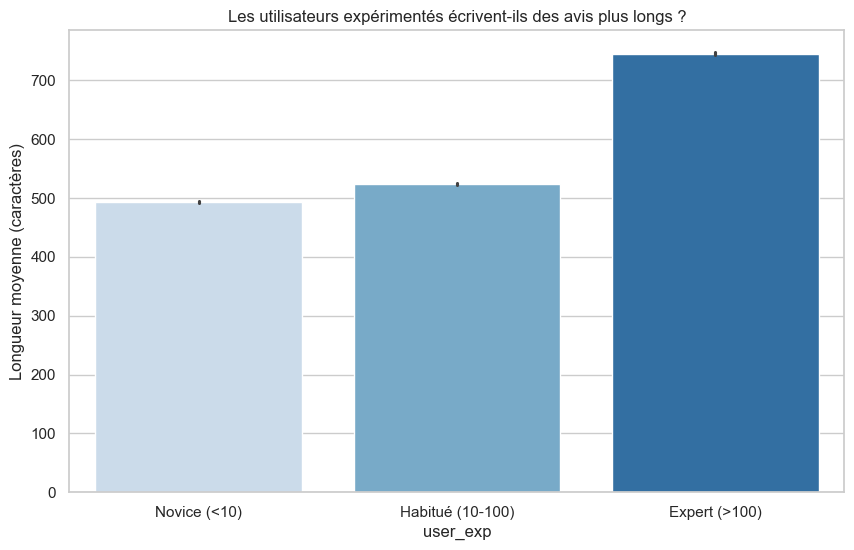

C:\Users\lucie\AppData\Local\Temp\ipykernel_396\4028037470.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_merged, x='stars', y='text_len', palette="RdYlGn") # Rouge vers Vert


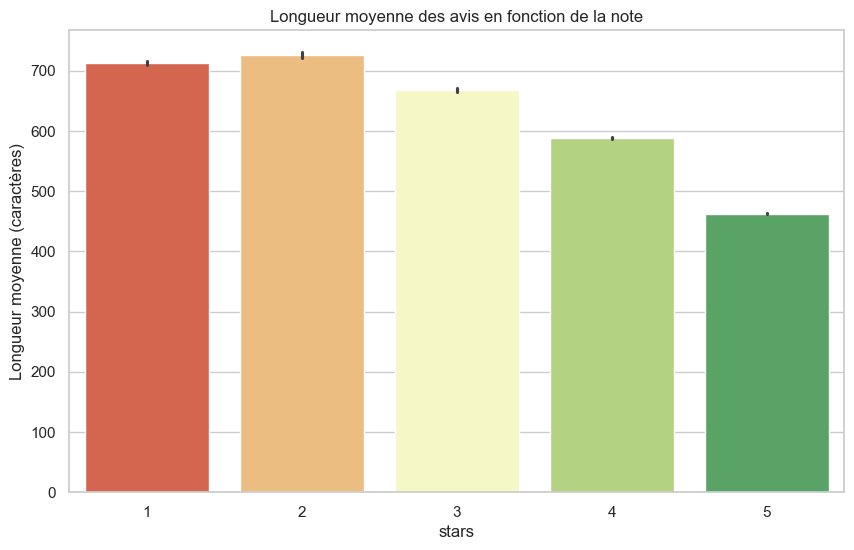

In [ ]:
# Calcul de la longueur du texte (nombre de caractères)
df_merged['text_len'] = df_merged['text'].fillna('').str.len()

# ANALYSE USER 1. Utilisateurs expérimentés vs Longueur
plt.figure(figsize=(10, 6))
sns.barplot(data=df_merged, x='user_exp', y='text_len', palette="Blues")
plt.title("Les utilisateurs expérimentés écrivent-ils des avis plus longs ?")
plt.ylabel("Longueur moyenne (caractères)")
plt.show()

# ANALYSE USER 2. Avis négatifs vs Longueur
# On regarde la longueur par note (1 étoile vs 5 étoiles)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_merged, x='stars', y='text_len', palette="RdYlGn") # Rouge vers Vert
plt.title("Longueur moyenne des avis en fonction de la note")
plt.ylabel("Longueur moyenne (caractères)")
plt.show()

-----
## 5. Analyse de Vocabulaire (BM25) BM25Okapi
Question : Quels sont les mots clés des avis positifs vs négatifs ?

- Est-ce que les utilisateurs expérimentés, ont tendance à faire des reviews plus détaillées ?

C'est la partie la plus technique. On utilise TF-IDF pour trouver les mots qui ont du "poids" (qui sont spécifiques) et pas juste les mots fréquents comme "le", "la", "et".

- BM25 fait ressortir les mots "percutants" des avis courts, là où TF-IDF privilégie souvent les mots des avis très longs et détaillés.

-------

- TF-IDF te donne les mots "stars" (ceux qui dominent le volume de texte).
- BM25 te donne les mots "significatifs" (ceux qui sont les plus informatifs par rapport à la taille de l'avis et leur rareté).

# ----- ---- TF-IDF ---- ------

In [ ]:
def get_top_tfidf_words(text_series, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(text_series)
    
    # On fait la moyenne des scores pour chaque mot
    scores = zip(vectorizer.get_feature_names_out(), np.asarray(X.mean(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:top_n]

print("Analyse TF-IDF en cours (cela peut prendre quelques secondes)...")

sample_neg = df_review[df_review['stars'] == 1]['text'].sample(10000, replace=True)
sample_pos = df_review[df_review['stars'] == 5]['text'].sample(10000, replace=True)

top_neg = get_top_tfidf_words(sample_neg)
top_pos = get_top_tfidf_words(sample_pos)

df_mots = pd.DataFrame({
    'Top Mots Négatifs': [mot for mot, score in top_neg],
    'Top Mots Positifs': [mot for mot, score in top_pos]
})

print("\n--- COMPARAISON DES VOCABULAIRES ---")
print(df_mots)

Analyse TF-IDF en cours (cela peut prendre quelques secondes)...

--- COMPARAISON DES VOCABULAIRES ---
  Top Mots Négatifs Top Mots Positifs
0              food             great
1           service              food
2             place             place
3              time              good
4              just           service
5              like              best
6             order           amazing
7               don              time
8              told              love
9              said             staff


# ----- ---- BM25 ---- ------

In [ ]:
def get_top_bm25_words(text_series, top_n=10):
    # Prétraitement : Nettoyage et Tokenisation
    def tokenize(text):
        text = str(text).lower()
        tokens = re.findall(r'\b\w\w+\b', text)
        return [w for w in tokens if w not in ENGLISH_STOP_WORDS]

    corpus = [tokenize(doc) for doc in text_series]
    
    # Initialisation du modèle BM25
    bm25 = BM25Okapi(corpus)
    
    word_counts = {}
    for doc in corpus:
        for word in set(doc):
            word_counts[word] = word_counts.get(word, 0) + 1

    word_scores = []
    for word, count in word_counts.items():
        if count > 50:  
            score = bm25.idf.get(word, 0) * count 
            word_scores.append((word, score))

    word_scores.sort(key=lambda x: x[1], reverse=True)
    
    return word_scores[:top_n]

print("Analyse BM25 en cours (échantillon de 10 000 avis par catégorie)...")

sample_neg = df_review[df_review['stars'] == 1]['text'].sample(10000, replace=True)
sample_pos = df_review[df_review['stars'] == 5]['text'].sample(10000, replace=True)

top_neg = get_top_bm25_words(sample_neg)
top_pos = get_top_bm25_words(sample_pos)

df_mots = pd.DataFrame({
    'Top Mots Négatifs (BM25)': [mot for mot, score in top_neg],
    'Score Négatif': [round(score, 2) for mot, score in top_neg],
    'Top Mots Positifs (BM25)': [mot for mot, score in top_pos],
    'Score Positif': [round(score, 2) for mot, score in top_pos]
})

print("\nCOMPARAISON DES VOCABULAIRES (BM25)")
print(df_mots)

Analyse BM25 en cours (échantillon de 10 000 avis par catégorie)...

--- COMPARAISON DES VOCABULAIRES (BM25) ---
  Top Mots Négatifs (BM25)  Score Négatif Top Mots Positifs (BM25)  \
0                     said        2783.74                     time   
1                     told        2783.45                     best   
2                      don        2783.24                  service   
3                      got        2778.44                 friendly   
4                     didn        2761.50                  amazing   
5                     good        2752.66                     just   
6                      did        2746.84                     good   
7                    asked        2734.81                delicious   
8                     went        2727.54                     like   
9                    order        2721.99                    staff   

   Score Positif  
0        2784.08  
1        2783.53  
2        2733.31  
3        2724.80  
4        2723.87  
5 